# Import

In [80]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV

# Load train data

In [81]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
train.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,534,531363010,20,RL,80.0,9605,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,159000
1,803,906203120,20,RL,90.0,14684,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,271900
2,956,916176030,20,RL,NaN,14375,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,1,2009,COD,Abnorml,137500
3,460,528180130,120,RL,48.0,6472,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,248500
4,487,528290030,80,RL,61.0,9734,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,167000


# Cleansing Data

In [82]:
# Change columns name
train.columns = train.columns.str.lower().str.replace(" ", "_")

In [83]:
df_null = train.isnull().sum().sort_values(ascending=False)

In [84]:
# pool_qc -> replace null to 0
# misc_feature -> dummy
# alley -> dummy
# fence -> dummy

df_null.head(30)

pool_qc           2185
misc_feature      2117
alley             2054
fence             1778
fireplace_qu      1066
lot_frontage       362
garage_yr_blt      122
garage_qual        122
garage_cond        122
garage_finish      122
garage_type        120
bsmt_exposure       69
bsmtfin_type_2      68
bsmtfin_type_1      67
bsmt_cond           67
bsmt_qual           67
mas_vnr_area        22
mas_vnr_type        22
bsmtfin_sf_2         1
bsmt_full_bath       1
bsmt_unf_sf          1
total_bsmt_sf        1
electrical           1
bsmtfin_sf_1         1
bsmt_half_bath       1
garage_cars          1
garage_area          1
mo_sold              0
full_bath            0
half_bath            0
dtype: int64

In [85]:
def data_cleaning(feature):
    train.columns = train.columns.str.lower().str.replace(" ", "_")
    test.columns = test.columns.str.lower().str.replace(" ", "_")
    train[feature] = train[feature].fillna(0)
    test[feature] = test[feature].fillna(0)

In [86]:
# Get top correlated features.
features_top10 = train.corr()[['saleprice']].sort_values(by='saleprice', ascending=False).index[1:11]
features_top15 = train.corr()[['saleprice']].sort_values(by='saleprice', ascending=False).index[1:16]
features_top20 = train.corr()[['saleprice']].sort_values(by='saleprice', ascending=False).index[1:21]

In [87]:
# Check null 
train[features_top20].isnull().sum().sort_values(ascending=False)

lot_frontage      362
garage_yr_blt     122
mas_vnr_area       22
garage_cars         1
garage_area         1
total_bsmt_sf       1
bsmt_full_bath      1
bsmtfin_sf_1        1
fireplaces          0
half_bath           0
open_porch_sf       0
wood_deck_sf        0
overall_qual        0
totrms_abvgrd       0
gr_liv_area         0
year_remod/add      0
full_bath           0
year_built          0
1st_flr_sf          0
lot_area            0
dtype: int64

In [88]:
data_cleaning(features_top20)

In [89]:
# Check null 
train[features_top20].isnull().sum().sort_values(ascending=False)

overall_qual      0
gr_liv_area       0
bsmt_full_bath    0
half_bath         0
open_porch_sf     0
wood_deck_sf      0
lot_frontage      0
bsmtfin_sf_1      0
fireplaces        0
totrms_abvgrd     0
mas_vnr_area      0
garage_yr_blt     0
year_remod/add    0
full_bath         0
year_built        0
1st_flr_sf        0
total_bsmt_sf     0
garage_area       0
garage_cars       0
lot_area          0
dtype: int64

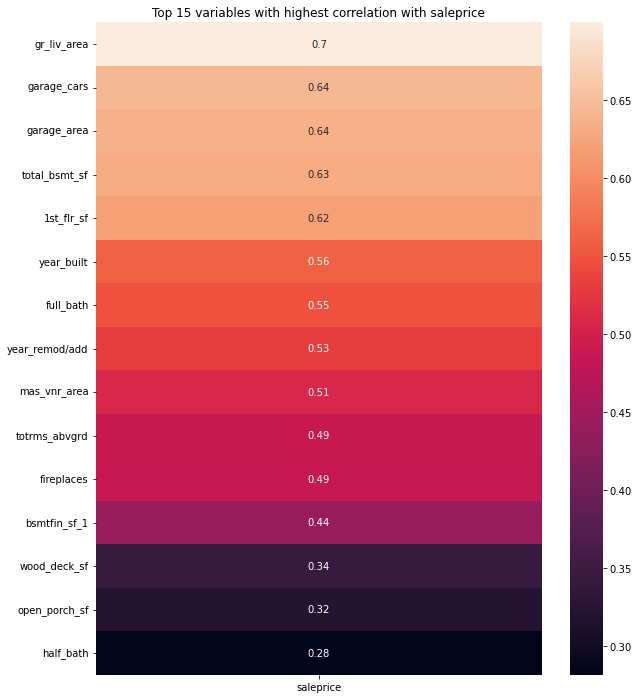

In [90]:
# Check correlation with saleprice to find interesting variables.
plt.figure(figsize=(10,12))
sns.heatmap(train.corr()[['saleprice']].sort_values(by='saleprice', ascending=False)[2:17],
            annot=True)
plt.title("Top 15 variables with highest correlation with saleprice");

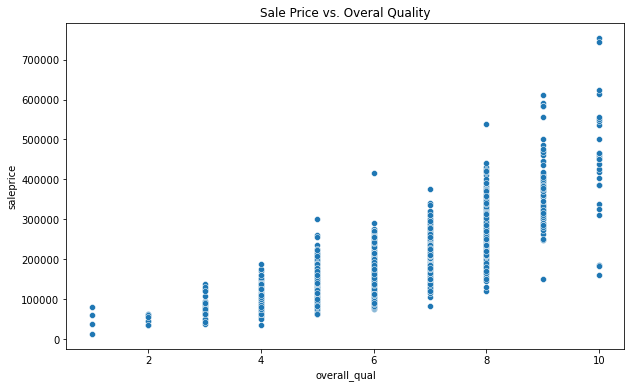

In [91]:
# Plot saleprice vs. overall_qual

plt.figure(figsize=(10,6))
sns.scatterplot(x=train['overall_qual'], y=train['saleprice'])
plt.title("Sale Price vs. Overal Quality");

## The chart looks normal

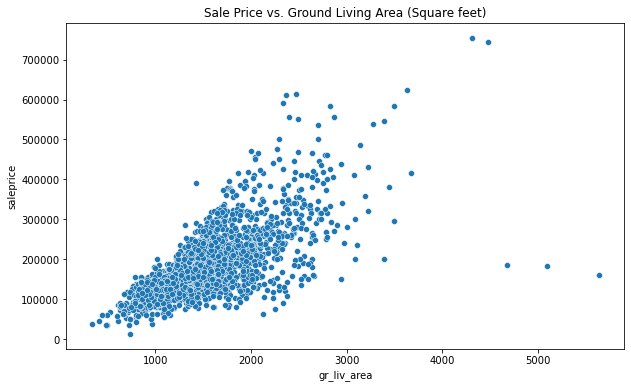

In [92]:
# Plot saleprice vs. gr_liv_area

plt.figure(figsize=(10,6))
sns.scatterplot(x=train['gr_liv_area'], y=train['saleprice'])
plt.title("Sale Price vs. Ground Living Area (Square feet)");

## There are some outliers for gr_liv_area over 4000 that could be removed

In [93]:
# Drop outlier
train = train[(train['gr_liv_area'] < 4000) | (train['saleprice'] > 400000)]

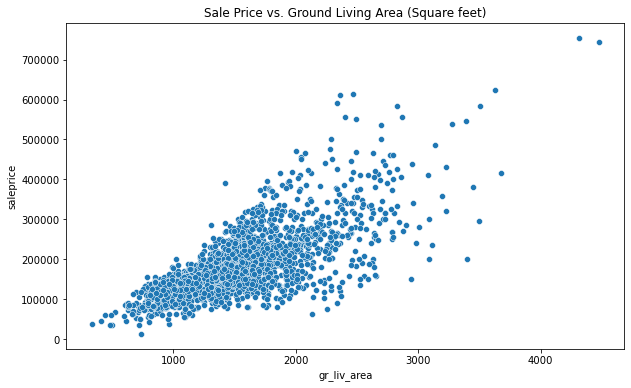

In [94]:
# Re-plot to check

plt.figure(figsize=(10,6))
sns.scatterplot(x=train['gr_liv_area'], y=train['saleprice'])
plt.title("Sale Price vs. Ground Living Area (Square feet)");


# EDA

In [95]:
# Get top correlated features.
features_top10 = train.corr()[['saleprice']].sort_values(by='saleprice', ascending=False).index[1:11]
features_top15 = train.corr()[['saleprice']].sort_values(by='saleprice', ascending=False).index[1:16]
features_top20 = train.corr()[['saleprice']].sort_values(by='saleprice', ascending=False).index[1:21]

Skewness: 1.777937011298179


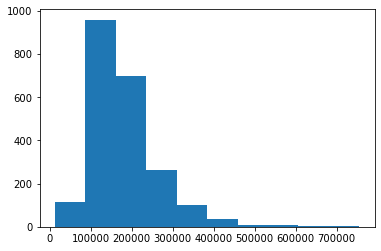

In [96]:
# Plot saleprice distribution.
print('Skewness:', train['saleprice'].skew())
plt.hist(train['saleprice']);

## The saleprice distribution is right skew so we could normalize it by using log e

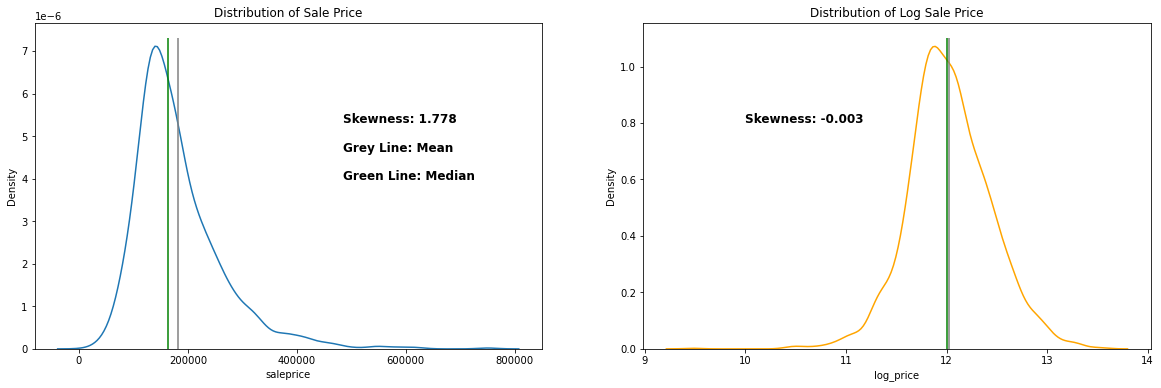

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))
ax1 = sns.kdeplot(ax = axes[0],x = "saleprice", data = train)
ax1.vlines(train["saleprice"].mean(),ymin = 0, ymax = 0.0000073, color = "grey")
ax1.vlines(train["saleprice"].median(),ymin = 0, ymax = 0.0000073, color = "green")
plt.text(6, 0.8, "Skewness: 1.778", horizontalalignment='left', size='large', color='black', weight='semibold')
plt.text(6, 0.7, "Grey Line: Mean", horizontalalignment='left', size='large', color='black', weight='semibold')
plt.text(6, 0.6, "Green Line: Median", horizontalalignment='left', size='large', color='black', weight='semibold')
ax1.title.set_text("Distribution of Sale Price")

train['log_price'] = np.log(train['saleprice'])
sns.kdeplot(ax = axes[1],x = "log_price", data = train, color = "orange")
plt.vlines(train["log_price"].mean(),ymin = 0, ymax = 1.1, color = "grey")
plt.vlines(train["log_price"].median(),ymin = 0, ymax = 1.1, color = "green")
plt.text(10, 0.8, "Skewness: -0.003", horizontalalignment='left', size='large', color='black', weight='semibold')
plt.title("Distribution of Log Sale Price");

The first graph on the left shows that the sale price is heavily skewed and should be transformed to reduce the residual. As the linear model require normality.

The second graph on the right shows that the log transformation of the sale price has reduced the skewness to almost zero.

### Continuous Variables
---

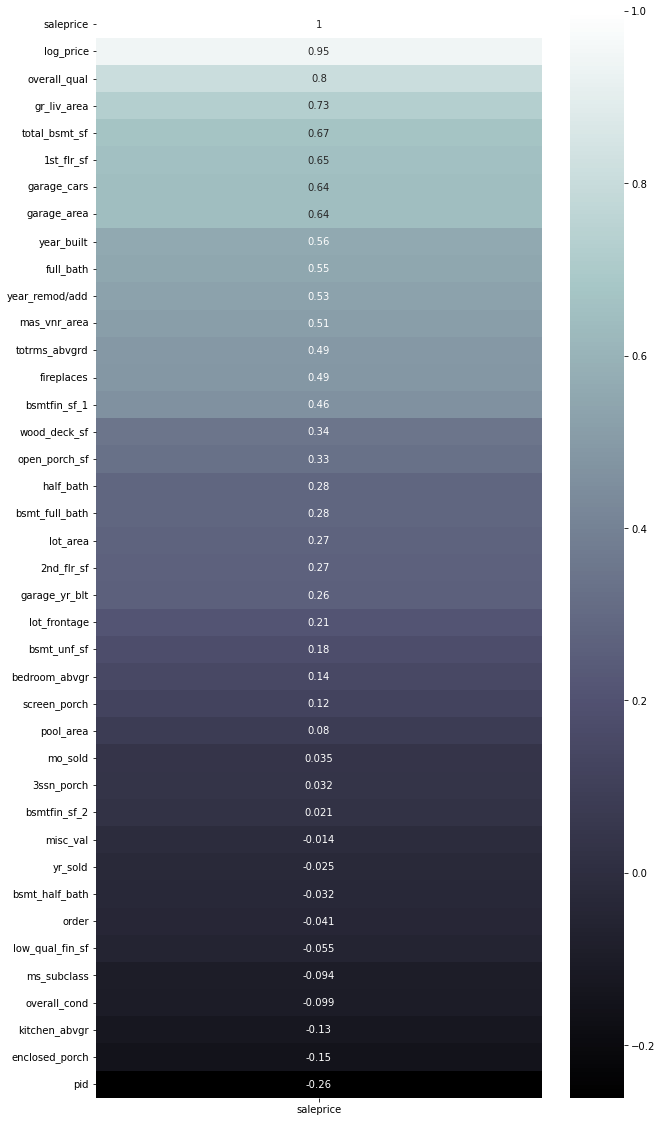

In [98]:
# Check correlation with saleprice
plt.figure(figsize=(10,20))
sns.heatmap(train.corr()[['saleprice']].sort_values(by='saleprice', ascending=False)
            , cmap='bone', annot=True);

In [99]:
# Note for continuous variables.
## 1. garage_yr_blt : has some missing data that turned to zero

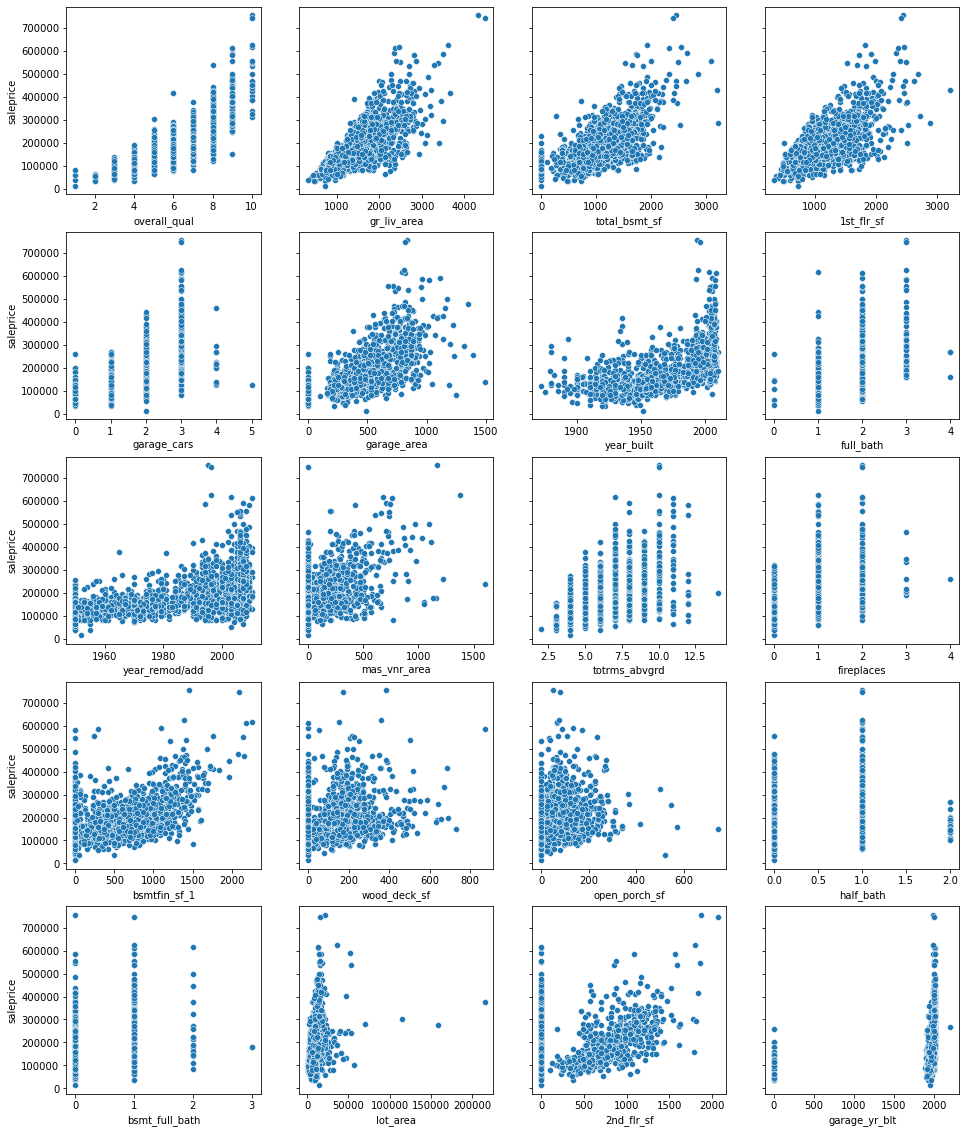

In [100]:
# Plot top 20 related features against saleprice.

fig, axes = plt.subplots(5, 4, figsize=(16,20))

for i, feat in enumerate(features_top20): ## iterate column name
    x = i // 4
    y = i % 4
    pl = sns.scatterplot(
        ax=axes[x,y],
        x=feat,
        y='saleprice',
        data=train)
    if y != 0:
        pl.set(ylabel=None, yticklabels=[])  ## show label only the leftmost plot 

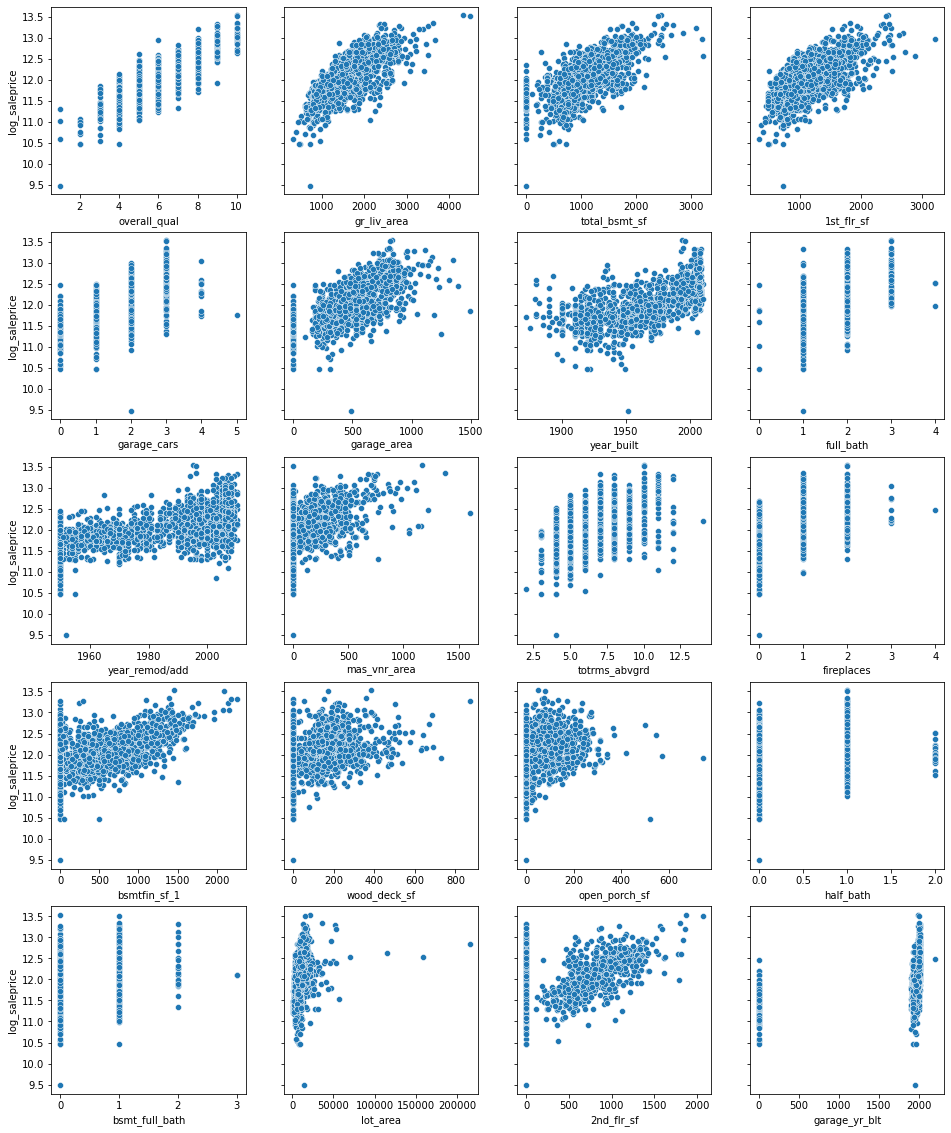

In [101]:
# Plot top 20 related features against log saleprice.

df_log = train.copy()
df_log['log_saleprice'] = np.log(train['saleprice'])

fig, axes = plt.subplots(5, 4, figsize=(16,20))

for i, feat in enumerate(features_top20): ## iterate column name
    x = i // 4
    y = i % 4
    pl = sns.scatterplot(
        ax=axes[x,y],
        x=feat,
        y='log_saleprice',
        data=df_log)
    if y != 0:
        pl.set(ylabel=None, yticklabels=[])  ## show label only the leftmost plot 

### Discrete Variables
---

In [102]:
# List all of object variables name
train.dtypes[train.dtypes == 'object']

ms_zoning         object
street            object
alley             object
lot_shape         object
land_contour      object
utilities         object
lot_config        object
land_slope        object
neighborhood      object
condition_1       object
condition_2       object
bldg_type         object
house_style       object
roof_style        object
roof_matl         object
exterior_1st      object
exterior_2nd      object
mas_vnr_type      object
exter_qual        object
exter_cond        object
foundation        object
bsmt_qual         object
bsmt_cond         object
bsmt_exposure     object
bsmtfin_type_1    object
bsmtfin_type_2    object
heating           object
heating_qc        object
central_air       object
electrical        object
kitchen_qual      object
functional        object
fireplace_qu      object
garage_type       object
garage_finish     object
garage_qual       object
garage_cond       object
paved_drive       object
pool_qc           object
fence             object


In [103]:
# Check number of discrete variables
'number of discrete variables', len(train.dtypes[train.dtypes == 'object'])

('number of discrete variables', 43)

In [104]:
def category_chart(data, features, target):
    """Create barcharts from iterating all categorical variables from 'x' list of variables 
    against y
    data = pd.DataFrame
    x = list of categorical variable name
    y = target variable"""
    # create subplots by number of x
    rows = math.ceil(len(features) / 4)
    fig, axes = plt.subplots(rows, 4, figsize=(20, rows * 5))
    
    # iterate column name
    for i, feat in enumerate(features): 
        x = i // 4
        y = i % 4
        if len(features) <= 4:
            axs = axes[y]
        else:
            axs = axes[x, y]
        pl = sns.barplot(
            ax = axs,
            x = feat,
            y = target,
            data = data)
        if y != 0:
            pl.set(ylabel=None, yticklabels=[])  ## show label only the leftmost plot 

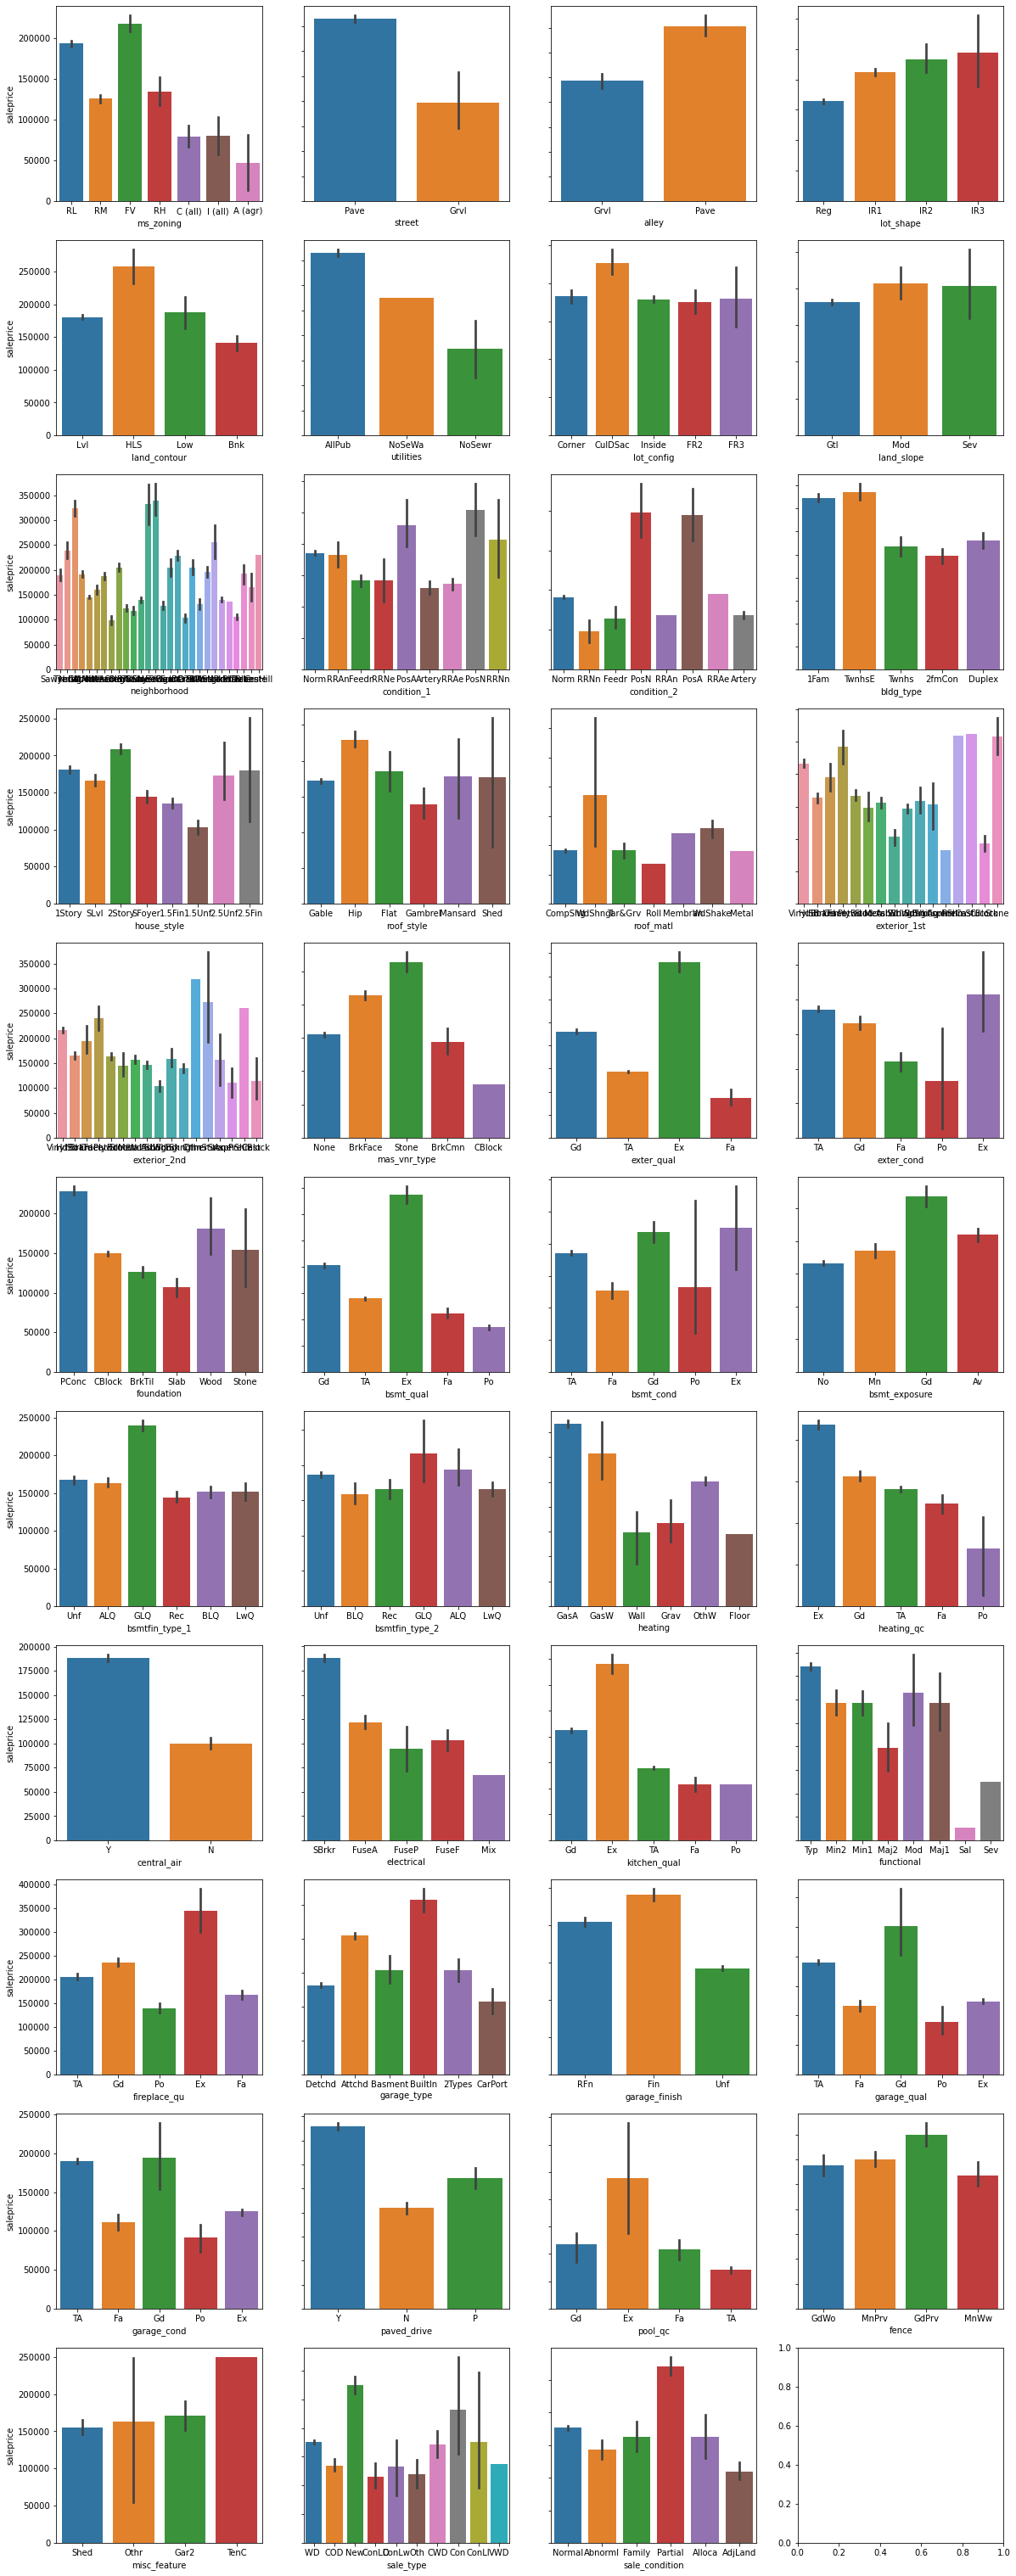

In [105]:
# Plot mean of saleprice for every categorical variable 

# get all categorical variables name
all_category = train.dtypes[train.dtypes == 'object'].index

# Plot barchart vs. saleprice
category_chart(train, all_category, 'saleprice')


In [106]:
# There are 43 categorical variable that are able to use in the model, but it is redundant.
# To capture only signal variables witout capturing noise, we take 2 indicators into account.
## 1. mean of saleprice by its category
## 2. number of data that create mean for the category

### Example of Unselected Variables

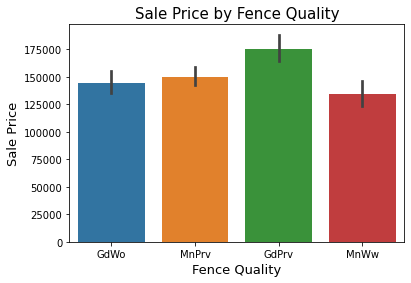

In [107]:
# Mean of saleprice groupby fence
sns.barplot(x = 'fence',
            y = 'saleprice',
            data = train)
plt.xlabel('Fence Quality', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Sale Price by Fence Quality', fontsize=15);

## There are no differenct sale prices among fence quality.
## We can exclude it from the model.

In [108]:
# Count & mean of saleprice groupby pool_qc
street_sum = train.groupby('street')['saleprice'].agg(['count', 'mean'])
street_sum.T
## Quality of road access to property could impact the sale price.
## Average price of properties that have access to paved road is 182,731 USD 
## while gravel road is 98,335,which is 1 time smaller.
## But the data for gravel road properties are too small to make a model more precise.

street,Grvl,Pave
count,9.000000,2185.000000
mean,98335.222222,182731.498856


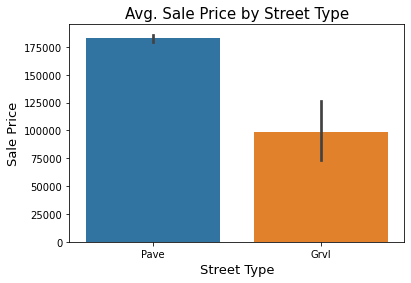

In [109]:
# Subplot mean and count of sale price by type of road access to property
sns.barplot(x = 'street',
            y = 'saleprice',
            data = train)
plt.xlabel('Street Type', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Avg. Sale Price by Street Type', fontsize=15);

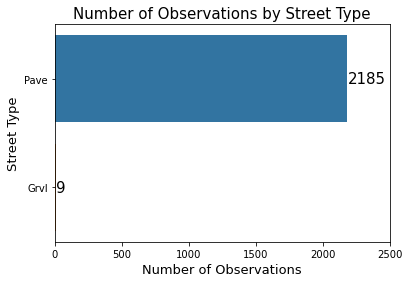

In [110]:
# Subplot mean and count of sale price by type of road access to property
ax = sns.barplot(y = train['street'].value_counts().index,
            x = train['street'].value_counts())
plt.xlabel('Number of Observations', fontsize=13)
plt.ylabel('Street Type', fontsize=13)
plt.title('Number of Observations by Street Type', fontsize=15)
plt.xlim(0, 2500)
ax.bar_label(ax.containers[0], fontsize=15);

In [111]:
# After plotting all categorical variables against saleprice,
# there are 21 features that could affect to saleprice and improve model perfromance.

### Survival Categorical Variables

In [112]:
# Name of dummies used in the model.
dummy_normal = ['bldg_type', 'lot_shape', 'land_contour', 'exter_qual'
          , 'sale_condition', 'functional', 'fireplace_qu', 'central_air'
          , "paved_drive", 'neighborhood']

dummy_group = ['ms_zoning', 'condition_1', 'sale_type', 'exterior_1st'
               , 'bsmt_qual', 'exterior_2nd', 'garage_qual'
               , 'garage_cond', 'heating_qc', 'kitchen_qual'
               , 'misc_feature']

notused_group = set(all_category) - (set(dummy_normal) |  set(dummy_group))

In [113]:
# To make a model more accurate in terms of predictive power,
# we separate variables into 2 groups by how they are feeded to the model
## 1: transform to dummy variables by using 'get_dummies' function
## 2: group value of dummy into 1 and 0 from top average sale price

### Sruvival group I - transform to dummy variables by using 'get_dummies' function

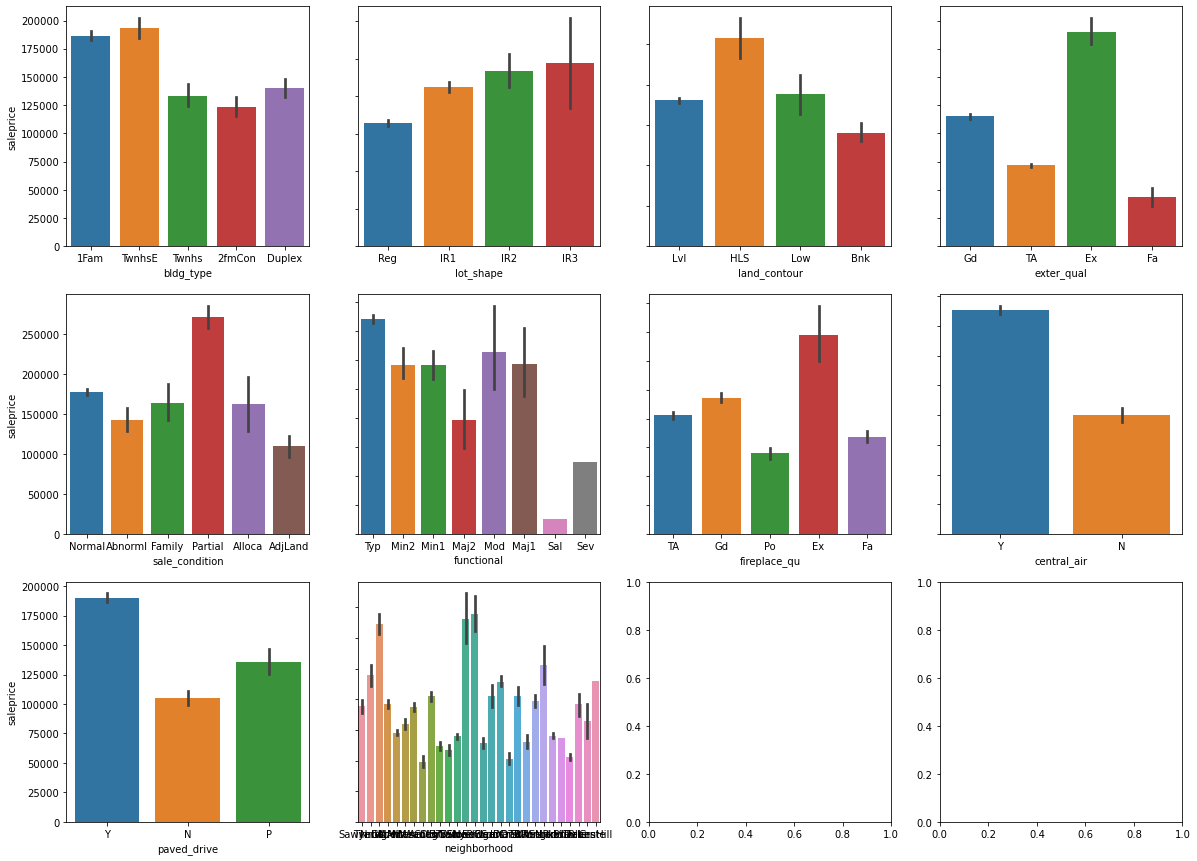

In [114]:
# Plot average price by group I dummies
category_chart(train, dummy_normal, 'saleprice')

In [115]:
train['neighborhood']

0       SawyerW
1       SawyerW
2        Timber
3       NridgHt
4       Gilbert
         ...   
2192    SawyerW
2193      SWISU
2194    Gilbert
2195    Edwards
2196    NridgHt
Name: neighborhood, Length: 2194, dtype: object

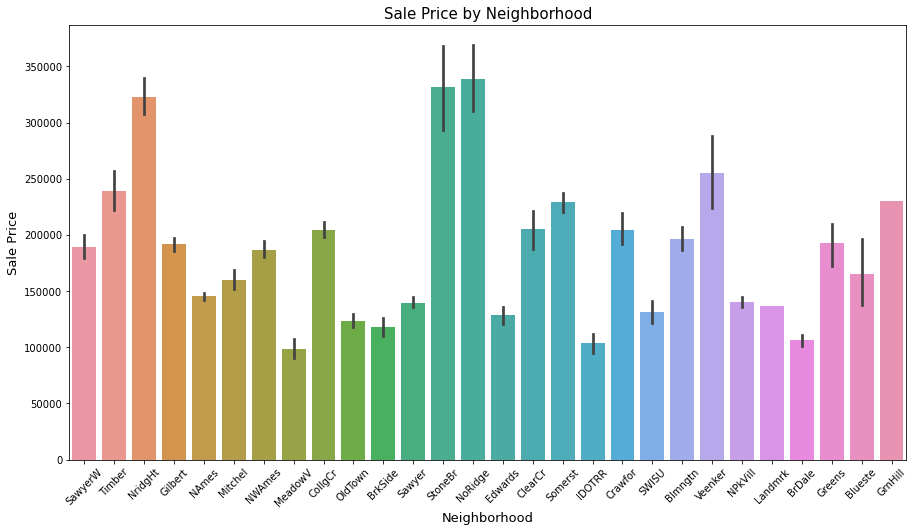

In [116]:
# 1st most affected dummy variable

# Neighborhood
plt.figure(figsize=(15, 8))
sns.barplot(x = 'neighborhood',
            y = 'saleprice',
            data = train)
plt.xticks(rotation=45)
plt.xlabel('Neighborhood', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Sale Price by Neighborhood', fontsize=15);

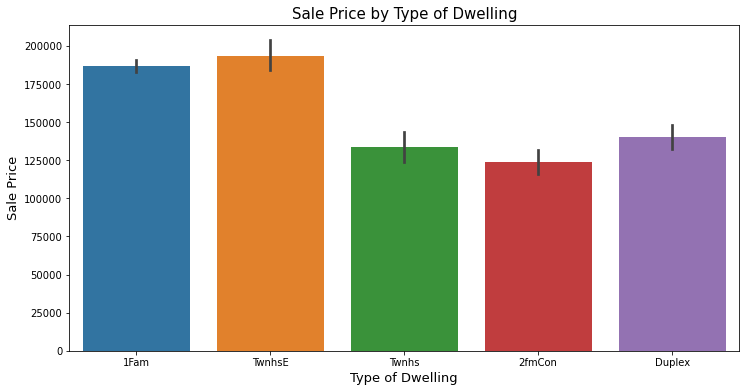

In [117]:
# 2nd most affected dummy variable

# Type of dwelling 
plt.figure(figsize=(12, 6))
sns.barplot(x = 'bldg_type',
            y = 'saleprice',
            data = train)
plt.xlabel('Type of Dwelling', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Sale Price by Type of Dwelling', fontsize=15);



### Sruvival group II - transform to dummy variables by using 'get_dummies' function

Analyses below are comparation between average sale price by each category and average sale price after grouping category into 0, 1

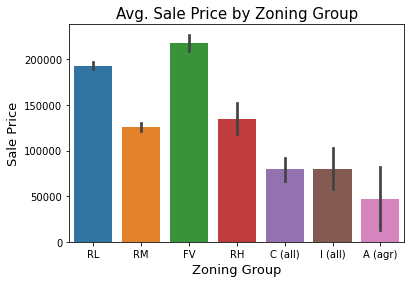

In [118]:
# General zoning classification of the sale
sns.barplot(x = 'ms_zoning',
            y = 'saleprice',
            data = train)
plt.xlabel('Zoning Group', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Avg. Sale Price by Zoning Group', fontsize=15);

# From the chart, zoning group can be separated into 2 different group
# by its average sale price.
## RL and FV that have similar property sale price around 200,000 USD 

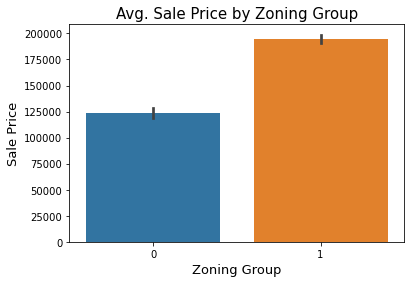

In [119]:
# Group data by sale price
ms_zoning_group = ['RL', 'FV']
x = train['ms_zoning'].apply(lambda x : 1 if x in ms_zoning_group else 0)
y = train['saleprice']

# Plot
sns.barplot(x = x,
            y = y)
plt.xlabel('Zoning Group', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Avg. Sale Price by Zoning Group', fontsize=15);

---

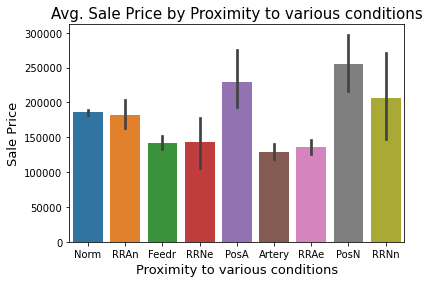

In [120]:
# Proximity to various conditions
sns.barplot(x = 'condition_1',
            y = 'saleprice',
            data = train)
plt.xlabel('Proximity to various conditions', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Avg. Sale Price by Proximity to various conditions', fontsize=15);

# PosA, PosN, PRNn are top 5 highest sale price for property and aloso have similar price that is around 250,000 USD
# We can group 5 of them into 1, other into 0

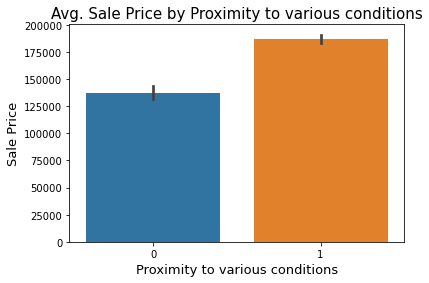

In [121]:
# Group data by sale price
## Differentiate value by sorting highest data
condition_1_group = train.groupby('condition_1')['saleprice'].agg(['count', 'mean'])\
.sort_values(by='mean', ascending=False)[:5].index

x = train['condition_1'].apply(lambda x : 1 if x in condition_1_group else 0)
y = train['saleprice']

# Plot
sns.barplot(x = x,
            y = y)
plt.xlabel('Proximity to various conditions', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Avg. Sale Price by Proximity to various conditions', fontsize=15);

---

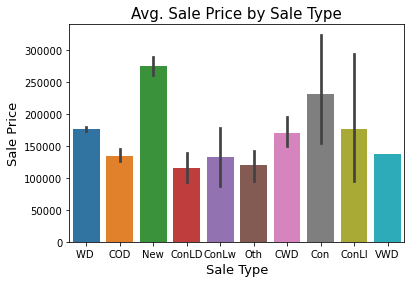

In [122]:
# Sale type
sns.barplot(x = 'sale_type',
            y = 'saleprice',
            data = train)
plt.xlabel('Sale Type', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Avg. Sale Price by Sale Type', fontsize=15);

# 'New' and 'Con' sale type are higher average price than others

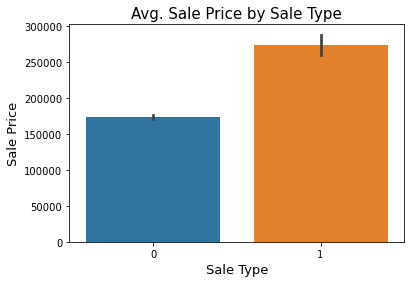

In [123]:
# Group data by sale price
## Differentiate value by sorting highest data
sale_type_group = train.groupby('sale_type')['saleprice'].mean()\
    .sort_values(ascending=False)[:2].index.to_list()

x = train['sale_type'].apply(lambda x : 1 if x in sale_type_group else 0)
y = train['saleprice']

# Plot
sns.barplot(x = x,
            y = y)
plt.xlabel('Sale Type', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Avg. Sale Price by Sale Type', fontsize=15);

---

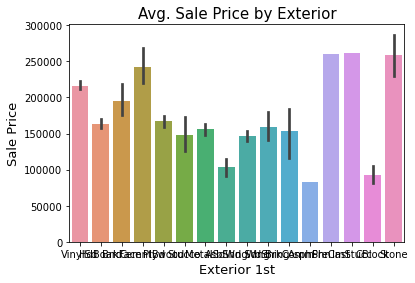

In [124]:
# Exterior covering on house
sns.barplot(x = 'exterior_1st',
            y = 'saleprice',
            data = train)
plt.xlabel('Exterior 1st', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Avg. Sale Price by Exterior', fontsize=15);

# there are 6 values that can group together from top average price

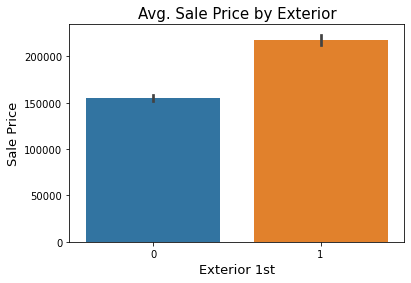

In [125]:
# Group data by sale price
## Differentiate value by sorting highest data
exterior_1st_group = train.groupby('exterior_1st')['saleprice'].mean()\
    .sort_values(ascending=False)[:6].index.to_list()


x = train['exterior_1st'].apply(lambda x : 1 if x in exterior_1st_group else 0)
y = train['saleprice']

# Plot
sns.barplot(x = x,
            y = y)
plt.xlabel('Exterior 1st', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Avg. Sale Price by Exterior', fontsize=15);

---

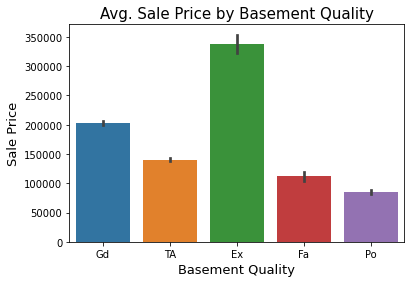

In [126]:
# Basement Quality
sns.barplot(x = 'bsmt_qual',
            y = 'saleprice',
            data = train)
plt.xlabel('Basement Quality', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Avg. Sale Price by Basement Quality', fontsize=15);

# Only 1 value is outstanding from others which is Ex quality

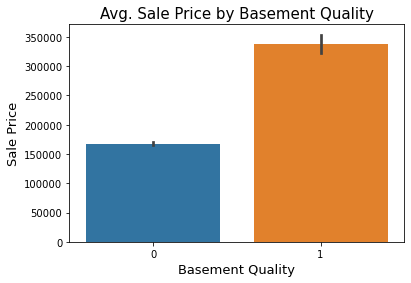

In [127]:
# Group data by sale price
## Differentiate value by sorting highest data
bsmt_qual_group = train.groupby('bsmt_qual')['saleprice'].mean()\
    .sort_values(ascending=False)[:1].index.to_list()

x = train['bsmt_qual'].apply(lambda x : 1 if x in bsmt_qual_group else 0)
y = train['saleprice']

# Plot
sns.barplot(x = x,
            y = y)
plt.xlabel('Basement Quality', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Avg. Sale Price by Basement Quality', fontsize=15);

---

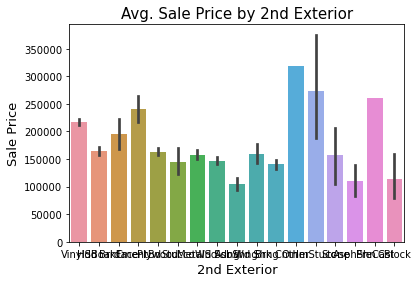

In [128]:
# 2nd Exterior covering on house
sns.barplot(x = 'exterior_2nd',
            y = 'saleprice',
            data = train)
plt.xlabel('2nd Exterior', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Avg. Sale Price by 2nd Exterior', fontsize=15);

# Top 3 values can be grouped

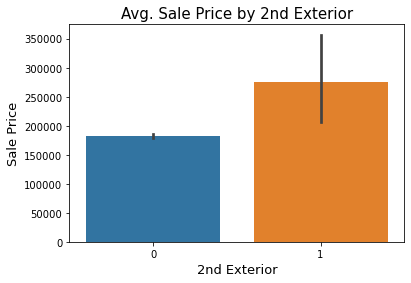

In [129]:
# Group data by sale price
## Differentiate value by sorting highest data
exterior_2nd_group = train.groupby('exterior_2nd')['saleprice'].mean()\
    .sort_values(ascending=False)[:3].index.to_list()

x = train['exterior_2nd'].apply(lambda x : 1 if x in exterior_2nd_group else 0)
y = train['saleprice']

# Plot
sns.barplot(x = x,
            y = y)
plt.xlabel('2nd Exterior', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Avg. Sale Price by 2nd Exterior', fontsize=15);

---

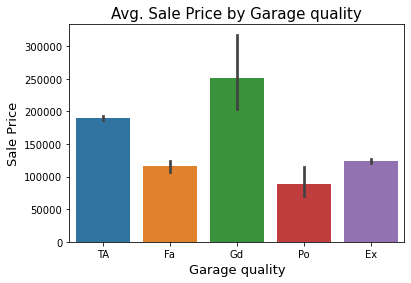

In [130]:
# Garage quality
sns.barplot(x = 'garage_qual',
            y = 'saleprice',
            data = train)
plt.xlabel('Garage quality', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Avg. Sale Price by Garage quality', fontsize=15);

# Only 1 value that can make highest average sale price in this group

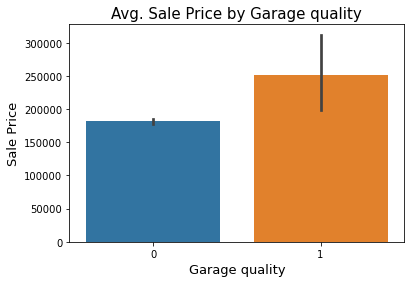

In [131]:
# Group data by sale price
## Differentiate value by sorting highest data
garage_qual_group = train.groupby('garage_qual')['saleprice'].mean()\
    .sort_values(ascending=False)[:1].index.to_list()

x = train['garage_qual'].apply(lambda x : 1 if x in garage_qual_group else 0)
y = train['saleprice']

# Plot
sns.barplot(x = x,
            y = y)
plt.xlabel('Garage quality', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Avg. Sale Price by Garage quality', fontsize=15);

---

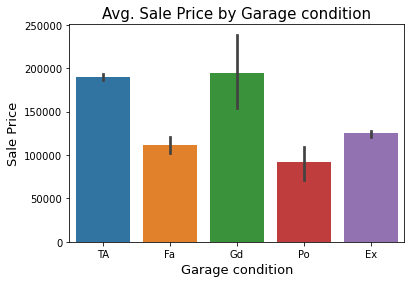

In [132]:
# Garage condition
sns.barplot(x = 'garage_cond',
            y = 'saleprice',
            data = train)
plt.xlabel('Garage condition', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Avg. Sale Price by Garage condition', fontsize=15);

# Top 2 garage condition can be grouped into 1 and others to 0

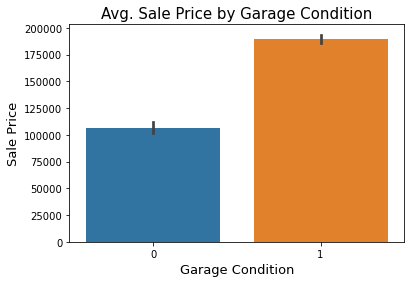

In [133]:
# Group data by sale price
## Differentiate value by sorting highest data
garage_cond_group = train.groupby('garage_cond')['saleprice'].mean()\
    .sort_values(ascending=False)[:2].index.to_list()


x = train['garage_cond'].apply(lambda x : 1 if x in garage_cond_group else 0)
y = train['saleprice']

# Plot
sns.barplot(x = x,
            y = y)
plt.xlabel('Garage Condition', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Avg. Sale Price by Garage Condition', fontsize=15);

---

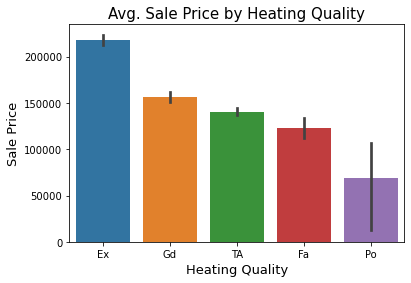

In [134]:
# Heating quality
sns.barplot(x = 'heating_qc',
            y = 'saleprice',
            data = train)
plt.xlabel('Heating Quality', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Avg. Sale Price by Heating Quality', fontsize=15);

# Top 2 heating quality can be grouped into 1 and others to 0

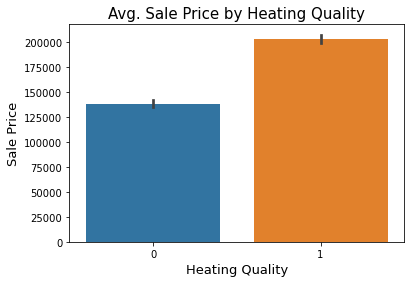

In [135]:
# Group data by sale price
## Differentiate value by sorting highest data
heating_qc_group = train.groupby('heating_qc')['saleprice'].mean()\
    .sort_values(ascending=False)[:2].index.to_list()



x = train['heating_qc'].apply(lambda x : 1 if x in heating_qc_group else 0)
y = train['saleprice']

# Plot
sns.barplot(x = x,
            y = y)
plt.xlabel('Heating Quality', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Avg. Sale Price by Heating Quality', fontsize=15);

---

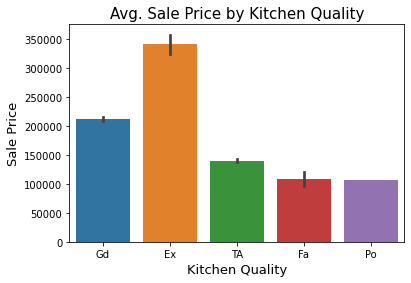

In [136]:
# Kitchen quality
sns.barplot(x = 'kitchen_qual',
            y = 'saleprice',
            data = train)
plt.xlabel('Kitchen Quality', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Avg. Sale Price by Kitchen Quality', fontsize=15);

# Excellecnt kitchen quality has highest value of average sale price

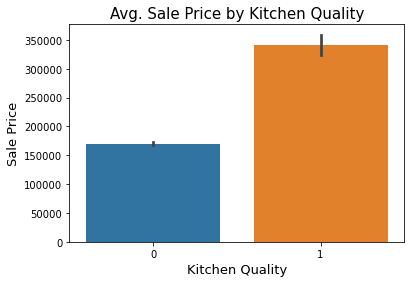

In [137]:
# Group data by sale price
## Differentiate value by sorting highest data
kitchen_qual_group = train.groupby('kitchen_qual')['saleprice'].mean()\
    .sort_values(ascending=False)[:1].index.to_list()

x = train['kitchen_qual'].apply(lambda x : 1 if x in kitchen_qual_group else 0)
y = train['saleprice']

# Plot
sns.barplot(x = x,
            y = y)
plt.xlabel('Kitchen Quality', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Avg. Sale Price by Kitchen Quality', fontsize=15);

---

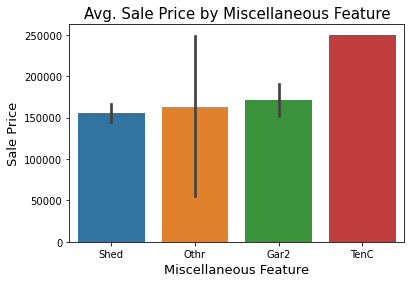

In [138]:
# Miscellaneous feature
sns.barplot(x = 'misc_feature',
            y = 'saleprice',
            data = train)
plt.xlabel('Miscellaneous Feature', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Avg. Sale Price by Miscellaneous Feature', fontsize=15);

# House that has tennis court tends to have higher sale price

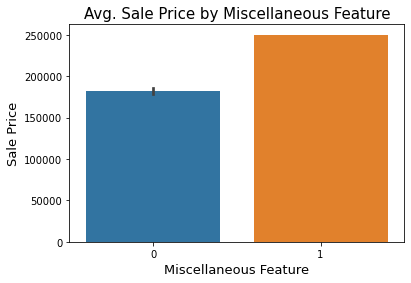

In [139]:
# Group data by sale price
## Differentiate value by sorting highest data
misc_feature_group = train.groupby('misc_feature')['saleprice'].mean()\
    .sort_values(ascending=False)[:1].index.to_list()


x = train['misc_feature'].apply(lambda x : 1 if x in misc_feature_group else 0)
y = train['saleprice']

# Plot
sns.barplot(x = x,
            y = y)
plt.xlabel('Miscellaneous Feature', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Avg. Sale Price by Miscellaneous Feature', fontsize=15);

# Make model
---

In [140]:
# create function to return model metrics

def r2_adj(model, X, y):
    """Calcualte adjusted R^2"""
    return 1 - (1-model.score(X, y)) * (len(y) - 1 ) / (len(y) - X.shape[1] - 1)

def reg_metrics(X, y, mode='normal', test_size=0.25):
    """Print model metrics and return regression model
    from given X, y, and mode 
    when mode is not normal, it returns RMSE of exponential y """
    
    # Split data.
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=test_size)
    
    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Create metrics - train
    y_train_preds = model.predict(X_train)
    train_mae = metrics.mean_absolute_error(y_train, y_train_preds)
    train_rmse = metrics.mean_squared_error(y_train, y_train_preds, squared=False)
    train_r2 = metrics.r2_score(y_train, y_train_preds)
    train_adj_r2 = r2_adj(model, X_train, y_train)
    
    # Create metrics - test
    y_test_preds = model.predict(X_test)
    test_mae = metrics.mean_absolute_error(y_test, y_test_preds)
    test_rmse = metrics.mean_squared_error(y_test, y_test_preds, squared=False)
    test_r2 = metrics.r2_score(y_test, y_test_preds)
    test_adj_r2 = r2_adj(model, X_test, y_test)
    
    # Additional metrics
    train_exp_rmse = 'none'
    test_exp_rmse = 'none'
    if mode != 'normal':
        train_exp_rmse = metrics.mean_squared_error(np.exp(y_train), np.exp(y_train_preds), squared=False)
        test_exp_rmse = metrics.mean_squared_error(np.exp(y_test), np.exp(y_test_preds), squared=False)
        
    print(f"""-----------Train Data-----------
MAE: {train_mae}
RMSE: {train_rmse}
EXP(RMSE): {train_exp_rmse}
R2: {train_r2}
Adj_R2: {train_adj_r2}
Cross Validation: {cross_val_score(model, X_train, y_train)}
Cross Validation Mean: {cross_val_score(model, X_train, y_train).mean()}
--------------------------------""")
    print(f"""-----------Test Data-----------
MAE: {test_mae}
RMSE: {test_rmse}
EXP(RMSE): {test_exp_rmse}
R2: {test_r2}
Adj_R2: {test_adj_r2}
--------------------------------""")
    return model

# Evaluate model

In [141]:
# Baseline model: Top 10 correlation variables

X = train[features_top10]
y = train['saleprice']

# Train model
reg_metrics(X, y, mode='normal')

-----------Train Data-----------
MAE: 23134.739387157795
RMSE: 33286.58572486896
EXP(RMSE): none
R2: 0.8397473875564326
Adj_R2: 0.8387666494141831
Cross Validation: [0.82718447 0.86239179 0.81011037 0.84187083 0.81614068]
Cross Validation Mean: 0.8315396265963981
--------------------------------
-----------Test Data-----------
MAE: 23324.979071684393
RMSE: 31464.14970144195
EXP(RMSE): none
R2: 0.8242746206061109
Adj_R2: 0.8210083496136594
--------------------------------


LinearRegression()

In [142]:
# Model 2: Top 15 correlation variables

X = train[features_top15]
y = train['saleprice']

# Train model
reg_metrics(X, y, mode='normal')

-----------Train Data-----------
MAE: 21551.366180300494
RMSE: 31309.975481470687
EXP(RMSE): none
R2: 0.8582144176496975
Adj_R2: 0.8569088413849617
Cross Validation: [0.83746498 0.87114387 0.83704575 0.86201793 0.84319736]
Cross Validation Mean: 0.850173976170257
--------------------------------
-----------Test Data-----------
MAE: 21486.103228665448
RMSE: 29417.839032442953
EXP(RMSE): none
R2: 0.8463883957433612
Adj_R2: 0.8420653674809793
--------------------------------


LinearRegression()

In [143]:
# Final model

# Get top15 features name
feature = features_top15.to_list()

# Set dummy variables
dummy_normal = ['bldg_type', 'lot_shape', 'land_contour', 'exter_qual'
          , 'sale_condition', 'functional', 'fireplace_qu', 'central_air'
          , "paved_drive", 'neighborhood']


dummy_group = ['ms_zoning', 'condition_1', 'sale_type', 'exterior_1st'
               , 'bsmt_qual', 'exterior_2nd', 'garage_qual'
               , 'garage_cond', 'heating_qc', 'kitchen_qual'
               , 'misc_feature']

# Combine top15 and dummy
feature = feature + dummy_normal

# Get data for X variabls
X = train[feature]

# Create dummy for X
X = pd.get_dummies(X, drop_first=True)

# Add grouped dummies to the model using dummy group from EDA part
for dummy in dummy_group:
    X = X.merge(train[dummy].apply(lambda x : 1 if x in eval(dummy+'_group') else 0),
       left_index=True, right_index=True)

# Interaction
X['overall_qual_interact'] = X['overall_qual'] * X['fireplaces']

# Log Transform
X['lot_area'] = np.log(train['lot_area'])

# Drop variables
X = X.drop(columns=['open_porch_sf', 'totrms_abvgrd'])

# Sort columns name
X = X.reindex(sorted(X.columns), axis=1)

# Logarithmic transformation
y = np.log(train['saleprice'])

# Train model
model = reg_metrics(X, y, mode='logy', test_size=0.01)

# Evaluation after log
y_preds = model.predict(X)
print('R2:', metrics.r2_score(np.exp(y), np.exp(y_preds)))
print('RMSE:', metrics.mean_squared_error(np.exp(y), np.exp(y_preds), squared=False))

-----------Train Data-----------
MAE: 0.07577811372409929
RMSE: 0.10703162758743205
EXP(RMSE): 19209.91744423272
R2: 0.9321971830176701
Adj_R2: 0.9294343644925032
Cross Validation: [0.91127149 0.90610766 0.93897153 0.91906153 0.92794156]
Cross Validation Mean: 0.9206707546828323
--------------------------------
-----------Test Data-----------
MAE: 0.045784462741805705
RMSE: 0.05931559730951155
EXP(RMSE): 11802.832729582826
R2: 0.9715668818519662
Adj_R2: 1.0093296168923236
--------------------------------
R2: 0.9443865516408726
RMSE: 19149.8695941905


#### Best RMSE: 19150.48850826363

# Prediction & Submission

In [144]:
## load test data
# test = pd.read_csv('./data/test.csv')
test.head()

,order,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,sale_condition
0,2127,907135180,20,RL,60.0,8070,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1,193,903206120,75,RL,0.0,7793,Pave,NaN,IR1,Bnk,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
2,2407,528181040,120,RL,40.0,6792,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2006,New,Partial
3,46,528175010,120,RL,44.0,6371,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,6,2010,New,Partial
4,2478,531379030,60,RL,70.0,8304,Pave,NaN,IR1,Lvl,...,0,0,NaN,GdPrv,NaN,0,7,2006,WD,Normal


In [145]:
test.columns = test.columns.str.lower().str.replace(" ", "_")

## Submission

In [146]:
train.groupby('neighborhood')['saleprice'].agg(['count', 'mean']).sort_values(by='mean', ascending=False)

,count,mean
neighborhood,,
NoRidge,52,338829.961538
StoneBr,36,331621.416667
NridgHt,135,322979.933333
Veenker,15,255403.333333
Timber,52,239055.500000
GrnHill,1,230000.000000
Somerst,149,228905.691275
ClearCr,30,204847.733333
Crawfor,76,204770.065789


### Clean Data

In [147]:
test[features_top10] = test[features_top10].fillna(0)

### Predict Data

In [148]:
# Prep X for test data
X_submit = test[feature]
X_submit = pd.get_dummies(X_submit, drop_first=True)

X_submit = X_submit.merge(test['ms_zoning'].apply(lambda x : 1 if x in ['RL','FV'] else 0),
       left_index=True, right_index=True)

X_submit = X_submit.merge(test['condition_1'].apply(lambda x : 1 if x in condition_1_group else 0),
       left_index=True, right_index=True)

X_submit = X_submit.merge(test['sale_type'].apply(lambda x : 1 if x in sale_type_group else 0),
       left_index=True, right_index=True)

X_submit = X_submit.merge(test['exterior_1st'].apply(lambda x : 1 if x in exterior_1st_group else 0),
       left_index=True, right_index=True)

X_submit = X_submit.merge(test['bsmt_qual'].apply(lambda x : 1 if x in bsmt_qual_group else 0),
       left_index=True, right_index=True)

X_submit = X_submit.merge(test['exterior_2nd'].apply(lambda x : 1 if x in exterior_2nd_group else 0),
       left_index=True, right_index=True)

X_submit = X_submit.merge(test['garage_qual'].apply(lambda x : 1 if x in garage_qual_group else 0),
       left_index=True, right_index=True)

X_submit = X_submit.merge(test['garage_cond'].apply(lambda x : 1 if x in garage_cond_group else 0),
       left_index=True, right_index=True)

X_submit = X_submit.merge(test['heating_qc'].apply(lambda x : 1 if x in heating_qc_group else 0),
       left_index=True, right_index=True)

X_submit = X_submit.merge(test['kitchen_qual'].apply(lambda x : 1 if x in kitchen_qual_group else 0),
       left_index=True, right_index=True)

X_submit = X_submit.merge(test['misc_feature'].apply(lambda x : 1 if x in misc_feature_group else 0),
       left_index=True, right_index=True)


X_submit['neighborhood_Landmrk'] = 0


# Interaction
X_submit['overall_qual_interact'] = X_submit['overall_qual'] * X_submit['fireplaces']


# Log Transform
X_submit['lot_area'] = np.log(test['lot_area'])



X_submit = X_submit.drop(columns=['open_porch_sf', 'totrms_abvgrd'])


X_submit = X_submit.reindex(sorted(X_submit.columns), axis=1)


preds_test = model.predict(X_submit)
preds_test[:10]

array([11.71072357, 12.1112094 , 12.20854842, 12.2910634 , 12.12253761,
       11.7583252 , 12.28379997, 11.96402846, 11.69114921, 11.77123436])

### Create submission table

In [157]:
## create dataframe with "Order" and prediction
pred_df = pd.DataFrame({'Order':test['order'], 'SalePrice':np.exp(preds_test)})
pred_df

,Order,SalePrice
0,2127,121871.631295
1,193,181899.461359
2,2407,200495.767469
3,46,217741.399578
4,2478,183971.772010
...,...,...
728,453,193769.763245
729,1352,170364.072988
730,197,119209.027098
731,2850,168515.647466


### Export submission table

In [155]:
## save to csv file for submission
## index = False
pred_df.to_csv('submission.csv', index=False)